<span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">⚡ Electricity Production Forecasting ⚡</span>

1. [Libraries and Utilities](#1)
2. [Loading Data](#2)
3. [Rolling Statistics](#3)
4. [Checking Stationarity](#4)
    - [Mean of Data](#5)
    - [Variance of Data](#6)
    - [Augmented Dickey-Fuller Test](#7)
5. [Converting Data to Stationary](#8)
    - [Logarithmic Transformation with Box-Cox](#9)
    - [Removing Trend with Moving Average](#10)
6. [Decomposition](#12)

7. [Forecasting Models](#14)
    - [Autoregression Model](#16)
    - [Moving Average Model](#17)
    - [ARIMA Model](#18)
    - [Auto ARIMA Model](#20)

<a id = "1"></a><h1 id="Libraries and Utilities"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Libraries and Utilities</span></h1>

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


<a id = "2"></a><h1 id="Loading Data"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Loading Data</span></h1>

In [2]:
col_names = ["date", "value"]
df = pd.read_csv("Electric_Production.csv",
                 names = col_names, header = 0, parse_dates = [0])
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


<a id = "3"></a><h1 id="Rolling Statistics"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Rolling Statistics</span></h1>


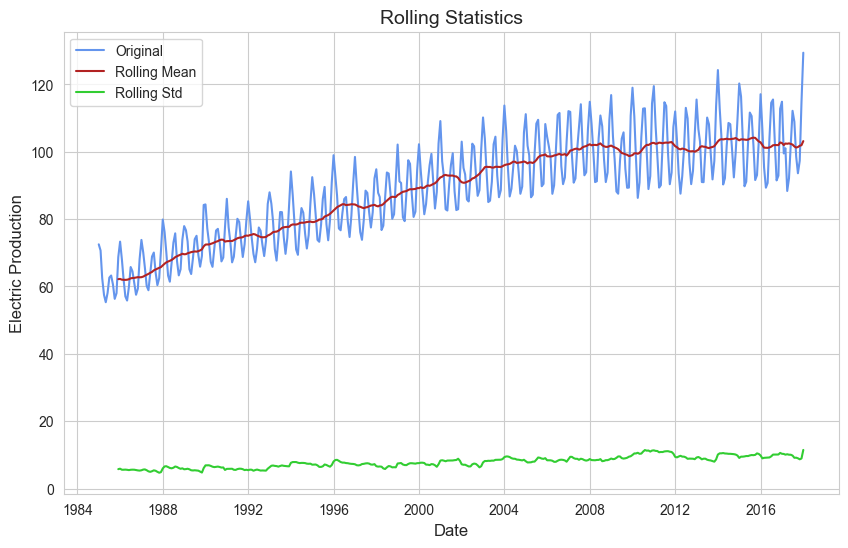

In [3]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

<a id = "4"></a><h1 id="Checking Stationarity"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Checking Stationarity</span></h1>

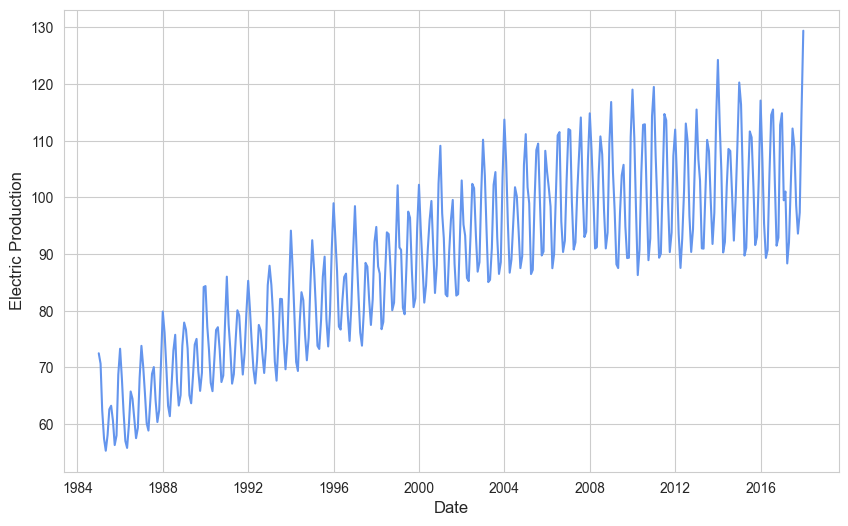

In [4]:
plt.figure(figsize = (10,6))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

Looking at the plot we can observe there is an **upward trend** over the period of time.

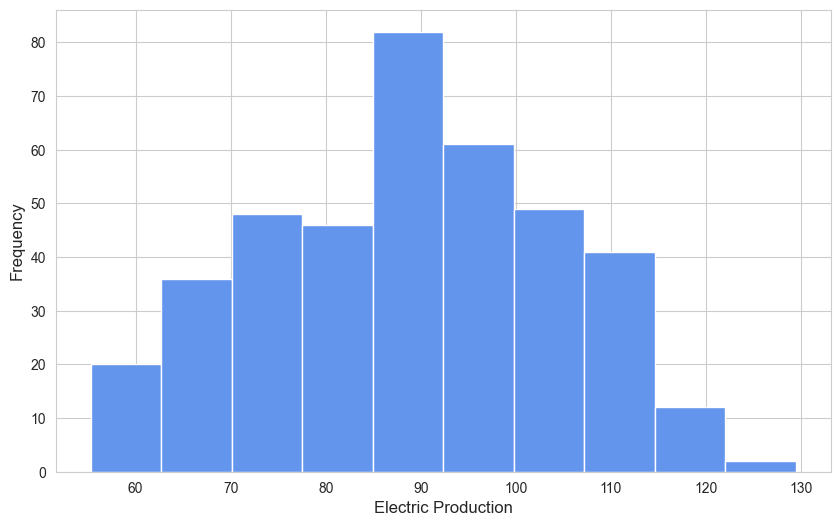

In [5]:
plt.figure(figsize = (10,6))
plt.hist(df['value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [6]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


We will proceed by splitting the data into two parts so that we can then check the **mean** and **variance** of the data.

<a id = "5"></a><h1 id="Mean of Data"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Mean of Data</p></h1>

In [7]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


<a id = "6"></a><h1 id="Variance"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Variance of Data</p></h1>

In [8]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


<a id = "7"></a><h1 id="Augmented Dickey-Fuller Test"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Augmented Dickey-Fuller Test</p></h1>


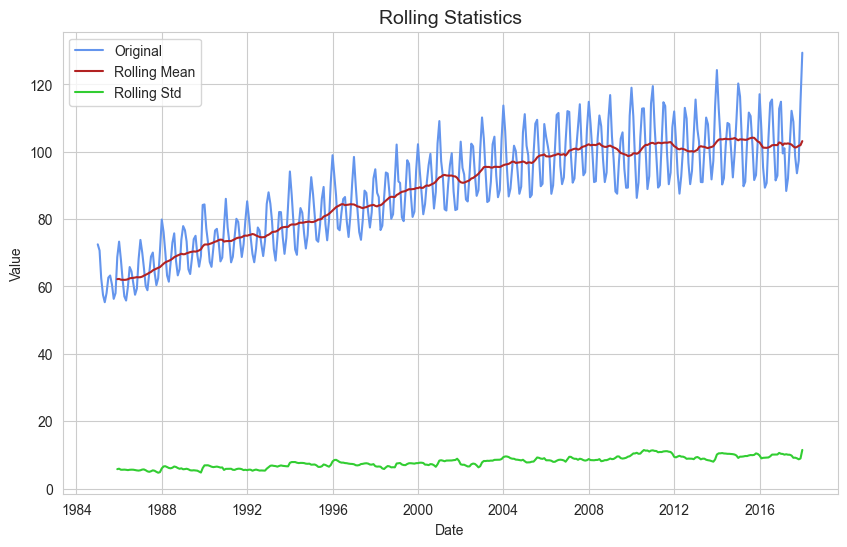

=== Augmented Dickey-Fuller Test Results ===
ADF Statistic     : -2.257
p-value           : 0.186
Critical Values   :
   1% level : -3.448
   5% level : -2.869
   10% level : -2.571
--------------------------------------------
Conclusion: ADF > Critical Value at 5%
→ Failed to reject H₀ → Time series is non-stationary.


In [9]:
def adfuller_test(ts, window=12):
    # Rolling Mean & Standard Deviation
    rolling_mean = ts.rolling(window).mean()
    rolling_std = ts.rolling(window).std()

    # Plot original data with rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(ts, color='cornflowerblue', label='Original')
    plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
    plt.plot(rolling_std, color='limegreen', label='Rolling Std')
    plt.title('Rolling Statistics', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Perform Augmented Dickey-Fuller Test
    result = adfuller(ts, autolag='AIC')

    print("=== Augmented Dickey-Fuller Test Results ===")
    print(f"ADF Statistic     : {result[0]:.3f}")
    print(f"p-value           : {result[1]:.3f}")
    print("Critical Values   :")
    for key, value in result[4].items():
        print(f"   {key} level : {value:.3f}")
    
    print("--------------------------------------------")
    # Interpretation
    if result[0] > result[4]["5%"]:
        print("Conclusion: ADF > Critical Value at 5%")
        print("→ Failed to reject H₀ → Time series is non-stationary.")
    else:
        print("Conclusion: ADF < Critical Value at 5%")
        print("→ Reject H₀ → Time series is stationary.")
adfuller_test(df)

<a id = "8"></a><h1 id="Converting Data to Stationary"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Converting Data to Stationary</span></h1>
<a id = "9"></a><h1 id="Logarithmic Transformation with Box-Cox"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Logarithmic Transformation with Box-Cox</p></h1>
The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

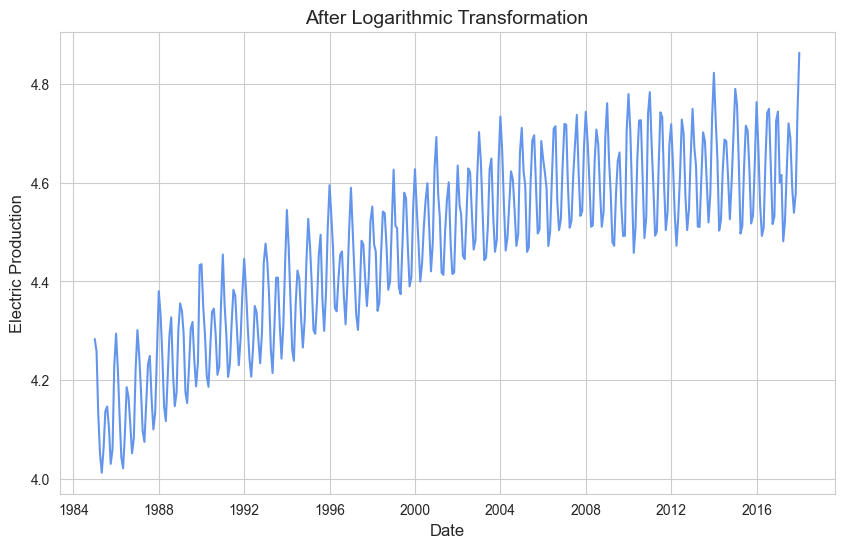

In [10]:
df_log_scaled = df
df_log_scaled['value'] = boxcox(df_log_scaled['value'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

<a id = "10"></a><h1 id="Removing Trend with Moving Average"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Removing Trend with Moving Average</p></h1>


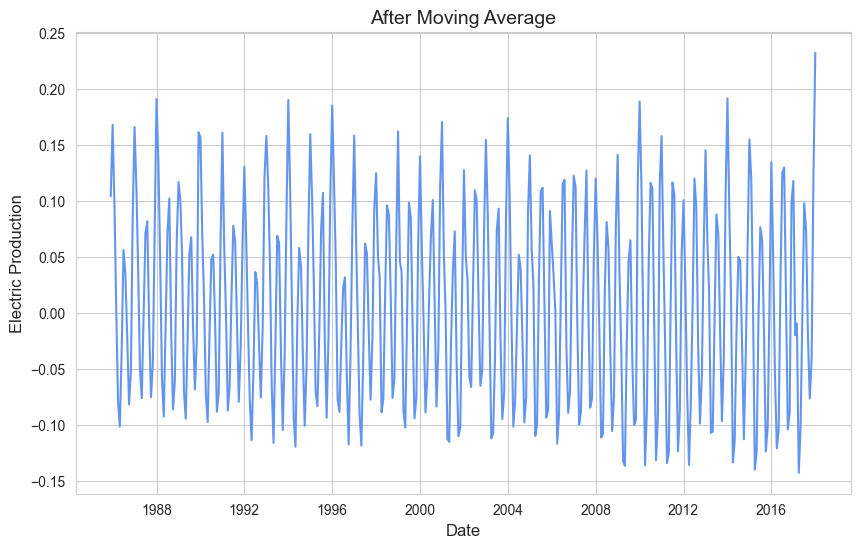

In [11]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

Let's test stationarity again.

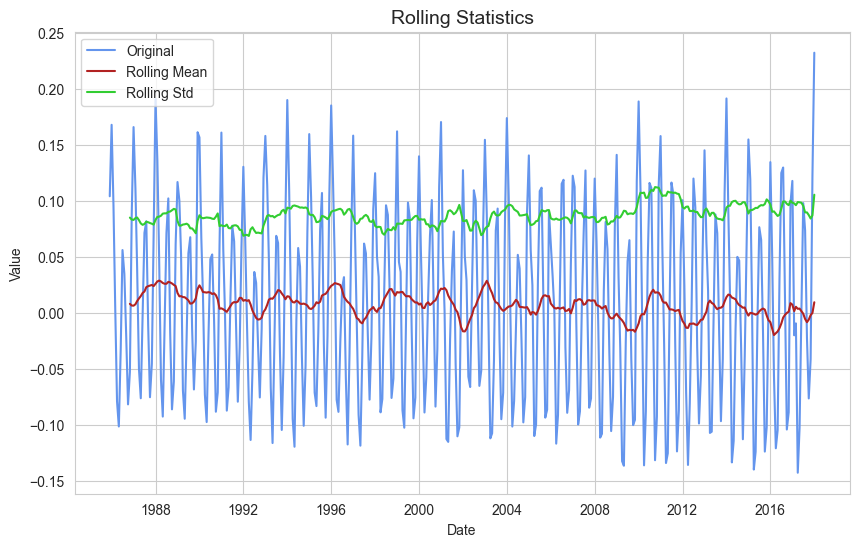

=== Augmented Dickey-Fuller Test Results ===
ADF Statistic     : -5.212
p-value           : 0.000
Critical Values   :
   1% level : -3.448
   5% level : -2.869
   10% level : -2.571
--------------------------------------------
Conclusion: ADF < Critical Value at 5%
→ Reject H₀ → Time series is stationary.


In [12]:
adfuller_test(df_log_scaled_ma, window = 12)

<a id = "12"></a><h1 id="Decomposition"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Decomposition</span></h1>

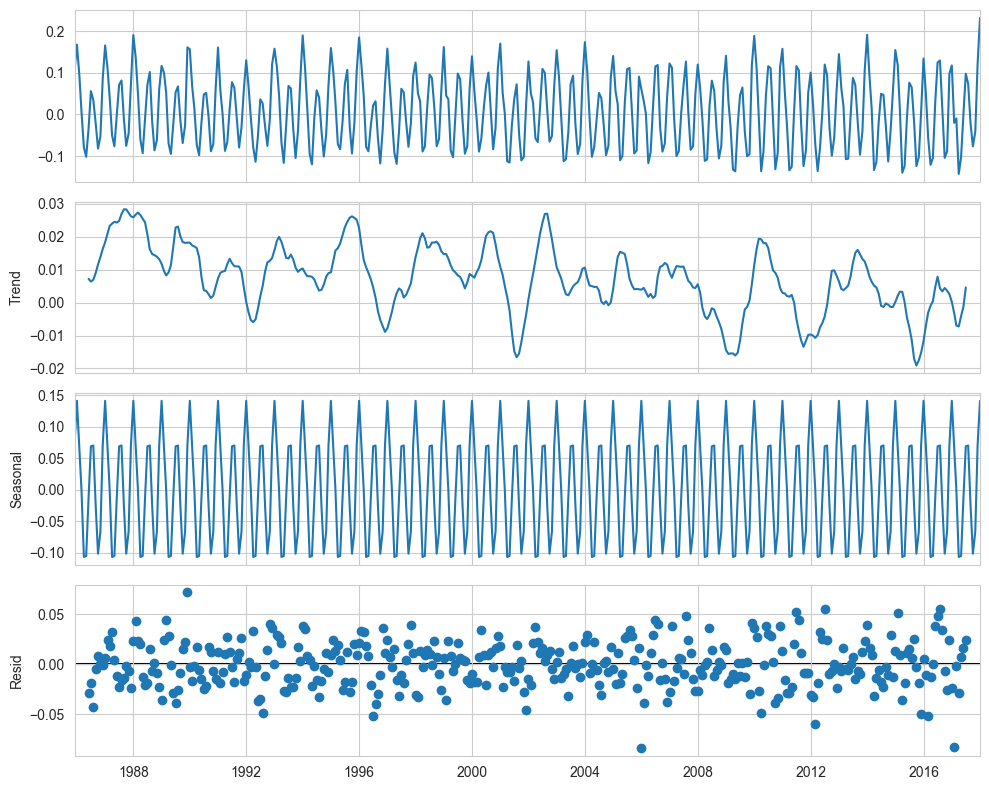

In [13]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_log_scaled_ma,
                                           model='additive')
df_seasonal_decompose.plot()
plt.show()

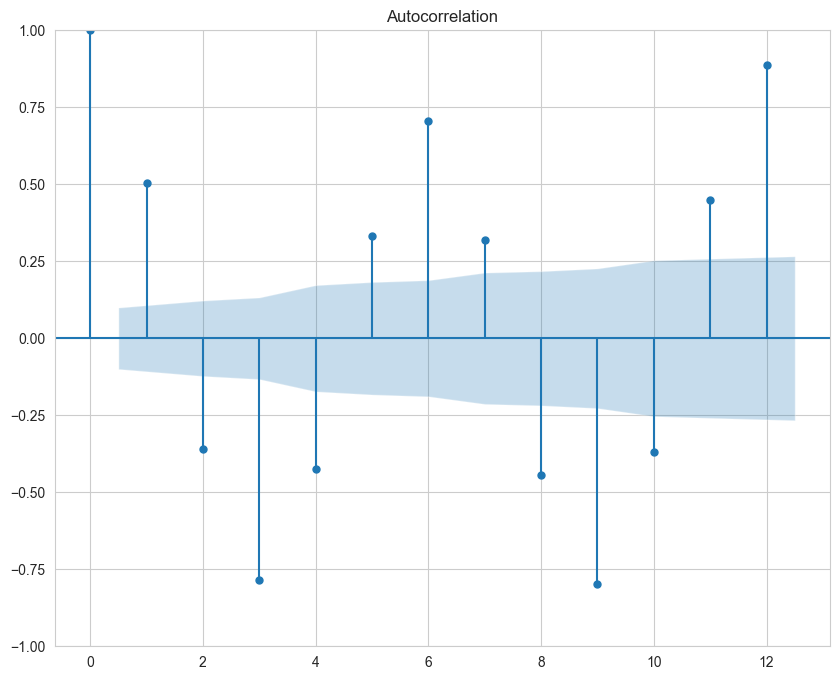

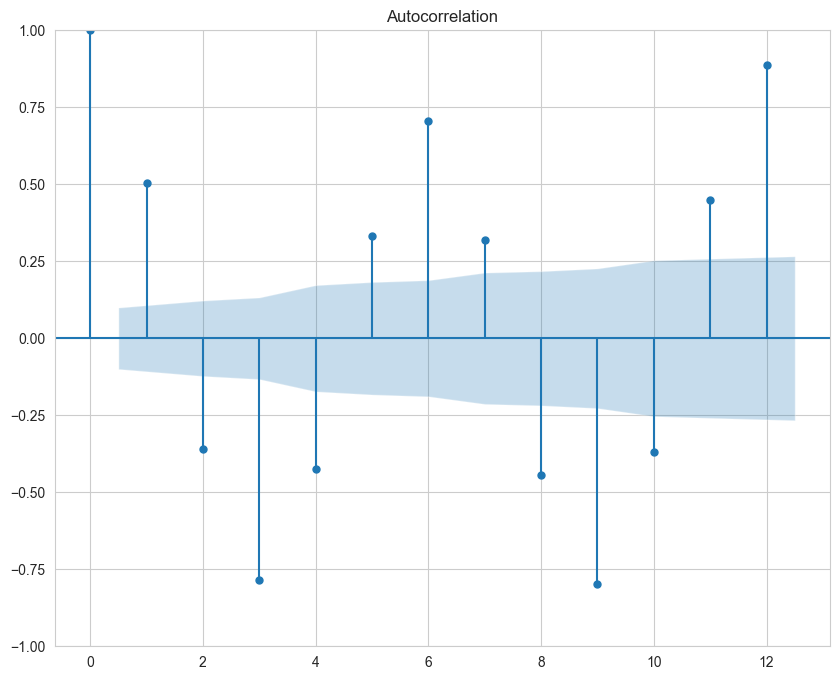

In [14]:
plot_acf(df_log_scaled_ma, lags=12)

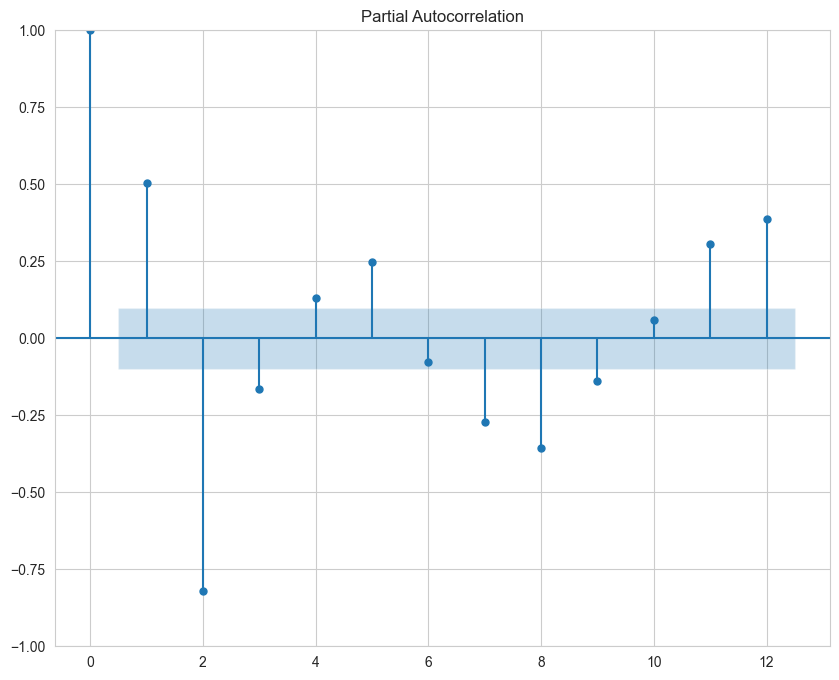

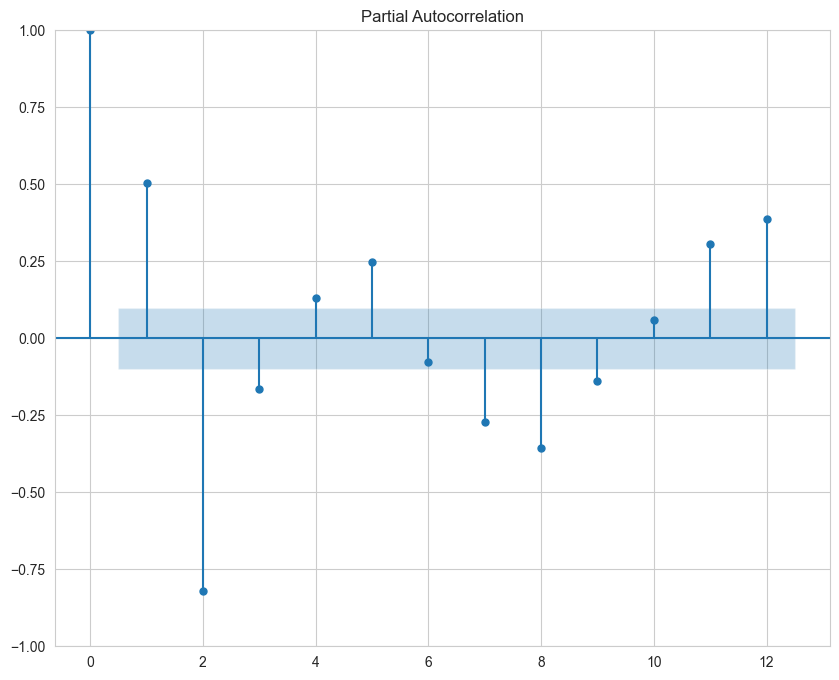

In [15]:
plot_pacf(df_log_scaled_ma, lags=12)

<a id="14"></a>
<h1 id="ForecastingModels">
  <span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC;">
    Forecasting Models
  </span>
</h1>


<a id = "16"></a><h1 id="Autoregression Model"><p  style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Autoregression Model</p></h1>


In [16]:
ar_values = df_log_scaled_ma.values
train = ar_values[1:len(ar_values)-10]
test = ar_values[len(ar_values)-10:]

# Adjust model parameters based on ACF and PACF analysis
model = SARIMAX(train, order=(2,1,0), seasonal_order=(1,0,1,12))


AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1)
ar_score = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
print('R2: {}'.format(round(r2, 4)))
print('AR MAE: {}'.format(round(ar_score,4)))

R2: 0.8075
AR MAE: 0.0372


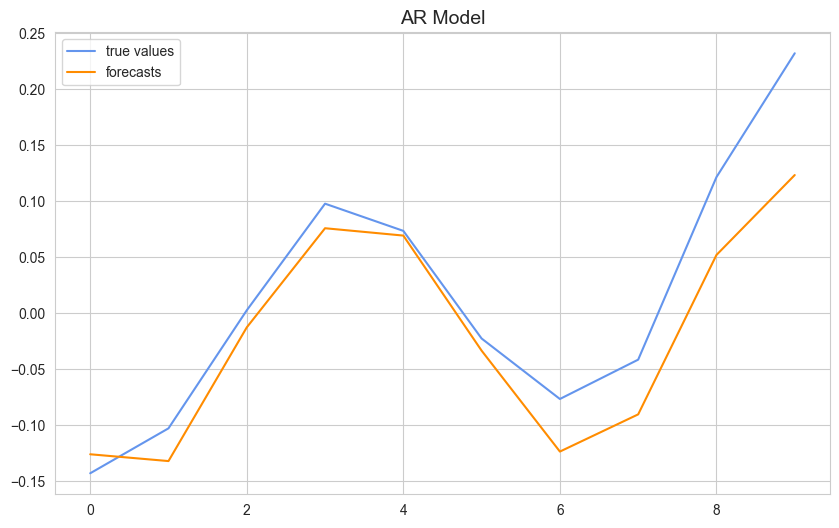

In [17]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "17"></a><h1 id="Moving Average Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Moving Average Model</p></h1>

In [18]:
model = SARIMAX(train, 
                order=(0, 1, 2), 
                seasonal_order=(1, 0, 1, 12))  

MA_model = model.fit(disp=False)

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1)
ma_score = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
print('R2: {}'.format(round(r2, 4)))
print('Seasonal MA MAE: {}'.format(round(ma_score, 4)))


R2: 0.8765
Seasonal MA MAE: 0.0277


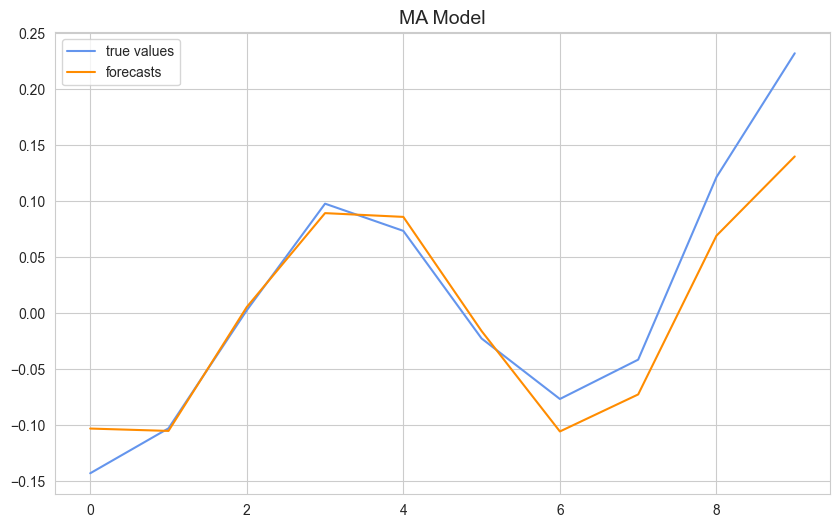

In [19]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "18"></a><h1 id="ARIMA Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">ARIMA Model</p></h1>


In [20]:
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)
print('R2: {}'.format(round(r2, 4)))
print('ARIMA MAE: {}'.format(round(arima_score, 4)))


R2: 0.8552
ARIMA MAE: 0.0283


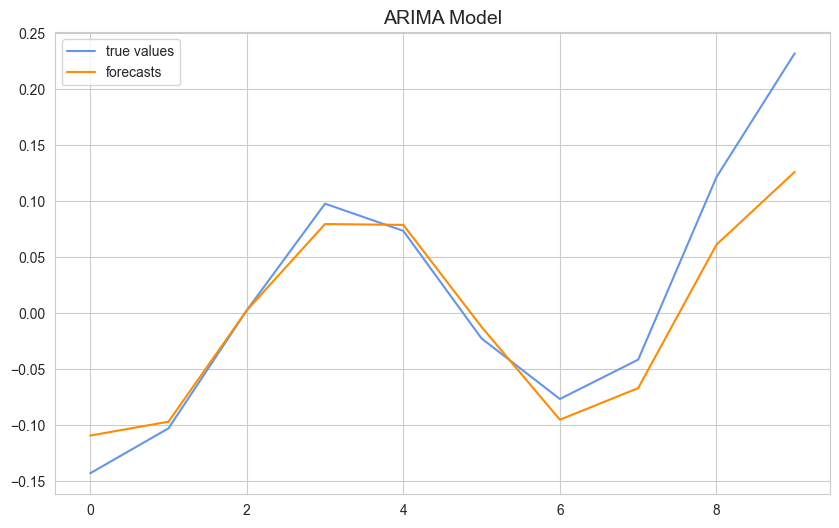

In [21]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "20"></a><h1 id="ARIMA Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Auto ARIMA Model</p></h1>

In [ ]:
auto_arima_model = auto_arima(
    train,
    seasonal=True,
    m=12,                     # Monthly seasonality
    trace=True,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',   # Ignore if a model fails to fit
    max_order=10,            # Cap on p + d + q + P + D + Q
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    start_P=0,
    seasonal_test='ocsb',    # Robust test for seasonality
    max_D=2,
    max_P=2,
    max_Q=2,
    information_criterion='aic',
    n_fits=50                # Increase search effort
)

forecast_days = len(test) 
forecast, conf_int = auto_arima_model.predict(n_periods=forecast_days, return_conf_int=True)

auto_arima_score = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)
print('R2: {}'.format(round(r2, 4)))
print("Auto ARIMA MAE:", round(auto_arima_score, 4))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-1307.831, Time=1.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-787.350, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1289.624, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-786.144, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1074.096, Time=0.59 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-1698.478, Time=1.38 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-1604.889, Time=2.37 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-1692.866, Time=3.91 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-1674.729, Time=4.97 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-1402.191, Time=3.52 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-1645.116, Time=3.92 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-1735.732, Time=5.54 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-1727.565, Time=6.52 sec
 ARIMA(1,0,0)

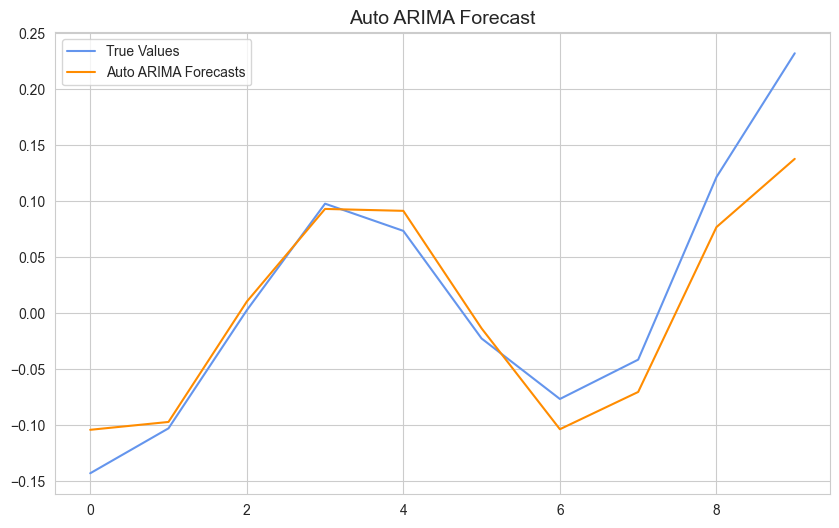

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(test, label="True Values", color="cornflowerblue")
plt.plot(forecast, label="Auto ARIMA Forecasts", color="darkorange")
plt.title("Auto ARIMA Forecast", fontsize=14)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [24]:
import pickle
with open("auto_arima_model.pkl", "wb") as f:
    pickle.dump(auto_arima_model, f)

In [27]:
with open("auto_arima_model.pkl", "rb") as f:
    model = pickle.load(f)

forecast_days = len(test) 
forecast, conf_int = model.predict(n_periods=forecast_days, return_conf_int=True)

auto_arima_score = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)
print('R2: {}'.format(round(r2, 4)))
print("Auto ARIMA MAE:", round(auto_arima_score, 4))

R2: 0.8802
Auto ARIMA MAE: 0.0278
